# Build a Machine Learning Model

This notebook is intended to use Machine Learning to build a (binary) classification model that will predict whether a receiver will be a **success or a bust** in the NFL, based on its college and NFL combine data. The key objective is to then test this predictive model against the 2020 draft class and to establish a ranking of the receivers (on their likeliness to be a success) for the teams' managers to use. Our goal is to improve the performance of our model by:
- doing features selection
- using multiple ML algorithms
- defining what a success / bust is. For recall, a success (respectively a bust) is a player where its aggregate receiving yards during the first 5 seasons in the NFL is above (below) a set threshold.

In [56]:
import Machine_Learning_Model
import importlib
importlib.reload(Machine_Learning_Model)
from Machine_Learning_Model import *

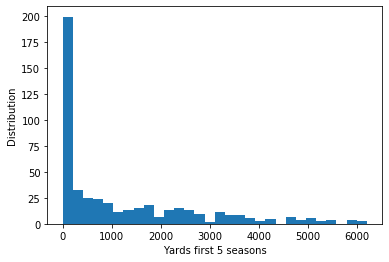

The data is zero-inflated... we build a classifier model rather than a linear regressor.
(488, 26)


In [54]:
tdcf = pd.read_csv('data_sets/tdcf.csv')

# Replacing an error in the scrapping about the draft age:
tdcf.loc[tdcf.combine_draft_age == 0,'combine_draft_age'] = np.nan

plt.hist(tdcf.rec_yards_ffs, bins = 30)
plt.xlabel('Yards first 5 seasons')
plt.ylabel('Distribution')
plt.show()
print('The data is zero-inflated... we build a classifier model rather than a linear regressor.')
print(tdcf.shape)

# 1) Selection of Numerical Features 

### by Correlation Matrix

We've seen on the previous notebook that categorical data (conference and class) has massive impact on the target, which is why we'll do a features selection only on the numerical columns. We start with the Pearson's  Correlation Matrix

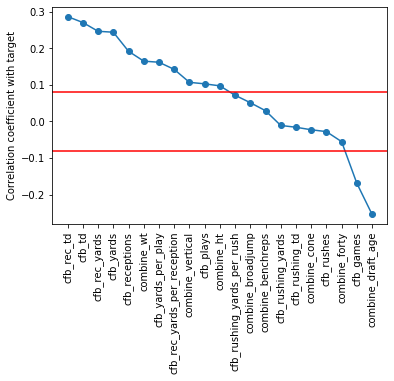

In [55]:
plt.plot(tdcf.corr(method='pearson').iloc[:-1,[-1]].sort_values(by = 'rec_yards_ffs', ascending = False),
        marker = 'o')
plt.xticks(rotation='vertical')
plt.axhline(y = 0.08, color = 'red')
plt.axhline(y = -0.08, color = 'red')
plt.ylabel('Correlation coefficient with target')
plt.show()

We notice many features land in the region where the correlation coefficient is less than 0.08 in absolute value. Let's do the same process with ExtraTreesClassifier from scikit-learn

### Tree-based Feature Importance: ExtraTreesClassifier

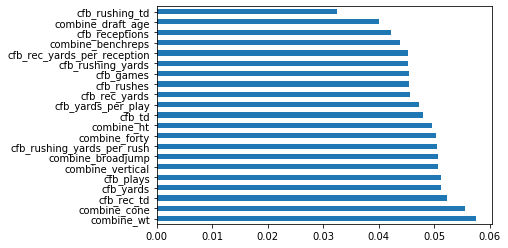

In [79]:
tdcfdna = tdcf.dropna()
X = tdcfdna.iloc[:,4:-1]
y = tdcfdna.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,y)

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending = False).plot(kind='barh')
plt.show()

From these analyses, we select the following features to run our model. We also avoid repetition of features, for example: cfb_td and cfb_rec_td, which respectively the aggregate number of TD's and the number of receiving TD's should be quite similar. We go with cfb_td in that case. Don't forget we also add the categorical features: cfb_conference and cfb_class

In [91]:
features_selected = ['cfb_td', 'cfb_yards', 'cfb_receptions','cfb_plays','cfb_yards_per_play',
'combine_wt', 'combine_cone', 'combine_vertical','combine_broadjump','combine_forty',
'cfb_games', 'combine_draft_age','cfb_conference', 'cfb_class']

In [92]:
df = tdcf[features_selected + ['rec_yards_ffs']]

# 1) Classification at fixed threshold: 200 yards

In this section, we fix the threshold at 200 yards. We then:
- operate features selection to select the most impactful data in relation to our target
- preprocess the data by normalizing some features and dealing with categorical statistics by using pandas' get_dummies
- run a LogisticRegressor
- run KNeighborsClassifier
- run DecisionTrees
- run SVM
- run RandomForest

In [36]:
threshold = 250
tdcf['success'] = (tdcf.rec_yards_ffs >= threshold)*1
tdcf.drop('rec_yards_ffs', axis = 1, inplace = True)
tdcf.success.value_counts(dropna = False)

1    284
0    204
Name: success, dtype: int64

In [5]:
# Remove entries with both cfb and combine data missing
wr1 = dropthenan(wr)

# Convert the cfbconference and cfbclass features to numerical data using pandas' get_dummies
wr1 = confclass(wr1)

In [6]:
# Set our featues X and target y
X = wr1.drop('yffs', axis = 1)
y = wr1.yffs

# Impute missing values
imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('yffs', axis = 1).columns.tolist())

# Normalize all feature numerical data (except the numerical columns associated with conference and class)
X = normalizeX(X, colsnum)
# Define our new target with respect to the threshold
y = splitter(y, 100)

### KNeighbors Classifier on a random train/test split data

In [7]:
knn = KNeighborsClassifier(n_neighbors = 18)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('score',knn.score(X_test, y_test))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score 0.7232142857142857
              precision    recall  f1-score   support

           0       0.60      0.34      0.44        35
           1       0.75      0.90      0.82        77

    accuracy                           0.72       112
   macro avg       0.68      0.62      0.63       112
weighted avg       0.70      0.72      0.70       112



### Logistic Regression on a random train/test split data

In [8]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10 29]
 [10 63]]
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        39
           1       0.68      0.86      0.76        73

    accuracy                           0.65       112
   macro avg       0.59      0.56      0.55       112
weighted avg       0.62      0.65      0.62       112



In [16]:
logreg = LogisticRegression()
cv_scores = cross_validate(logreg, X, y, cv = 10)

print('Using a cross validation test on a 10-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 10-fold sample, the average score returned is 0.6672830725462305


### ROC Curve (varying threshold p) on a random train/test split data: TPR and FPR

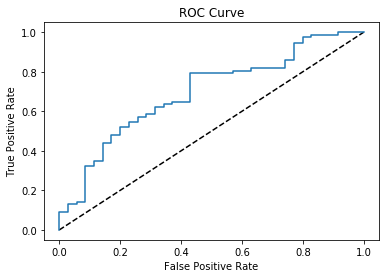

The AUC score is: 0.6949907235621522
The Log Loss is: 0.5704160773246153


In [19]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

logreg.fit(X_train,y_train)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The AUC score is:',roc_auc_score(y_test, y_pred_prob))
print('The Log Loss is:',log_loss(y_test, y_pred_prob))

For each value predicted, we return the tpr and fpr depending on the threshold. Those are defined in the two cells below.

In [360]:
j = 3 
tpr[j], fpr[j], thresholds[j]

(0.02531645569620253, 0.030303030303030304, 0.9090571442909853)

In [359]:
mat = np.transpose([y_pred_prob,y_pred,y_test])

tp = [1 for i in range(len(mat)) if mat[i,0] >= thresholds[j] and mat[i,2] == 1]
tn = [1 for i in range(len(mat)) if mat[i,0] < thresholds[j] and mat[i,2] == 0]
fp = [1 for i in range(len(mat)) if mat[i,0] >= thresholds[j] and mat[i,2] == 0]
fn = [1 for i in range(len(mat)) if mat[i,0] < thresholds[j] and mat[i,2] == 1]

len(tp) / (len(tp) + len(fn)), len(fp) / (len(fp) + len(tn))

(0.02531645569620253, 0.030303030303030304)

# 2) Classification with varying threshold

# 3) Testing on the Class of 2020

We import the data for the class of 2020 and label it **X_test**. Everything is done so that the test data is formated identically to the training data. The first 6 columns wr_2020 contain additional draft information. It is very important to keep the row sorting of the test data so that it matches with those 6 columns

In [17]:
import Machine_Learning_Model_2_Scraping
import importlib
importlib.reload(Machine_Learning_Model_2_Scraping)
from Machine_Learning_Model_2_Scraping import *

# url_wr_draft_2020 = 'https://www.pro-football-reference.com/play-index/draft-finder.cgi?request=1&year_min=2020&year_max=2020&draft_slot_min=1&draft_slot_max=500&pick_type=overall&pos%5B%5D=wr&conference=any&show=all&order_by=default'
# table_draft_2020 = main(url_wr_draft_2020)

In [557]:
wr_2020 = table_draft_2020.drop(drop_columns, axis = 1)
wr_2020 = wr_2020[reorder_columns]
wr_2020 = wr_2020.rename(columns=renaming_dict)
wr_2020 = correct_switch(wr_2020, [13])
wr_2020 = wr_2020.replace('',np.nan)
for i in range(9,30):
    wr_2020.iloc[:,i] = wr_2020.iloc[:,i].astype(float)
    
wr_2020.to_csv('data_sets/wr_2020.csv', index=False)

Let's capture the testing data **X_test**

In [34]:
wr_2020 = pd.read_csv('data_sets/wr_2020.csv')

wr_2020 = wr_2020.drop('combinebenchreps', axis = 1)
X_test = wr_2020.iloc[:,7:]

Let's capture the training data **X_train**

In [35]:
wro = dropthenan(wr)
X_train = wro.drop('yffs', axis = 1)
y_train = wro.yffs

In [38]:
X_train

,cfbgames,cfbreceptions,cfbrecyards,cfbrecyardsperreception,cfbrectd,cfbrushattempts,cfbrushyards,cfbrushyardsperattempt,cfbrushtd,cfbscrimmages,cfbyards,cfbyardsfromscrimmage,cfbtd,combineht,combinewt,combineforty,combinevertical,combinebroadjump,combinecone,combineshuttle,cfbconference_ACC,cfbconference_American,cfbconference_Big 12,cfbconference_Big East,cfbconference_Big Ten,cfbconference_CUSA,cfbconference_Ind,cfbconference_MAC,cfbconference_MWC,cfbconference_Pac-10,cfbconference_Pac-12,cfbconference_SEC,cfbconference_Sun Belt,cfbconference_WAC,cfbclass_FR,cfbclass_JR,cfbclass_SO,cfbclass_SR
0,32.0,166.0,2619.0,15.8,23.0,7.0,105.0,15.0,0.0,173.0,2724.0,15.7,23.0,76.0,211.0,4.48,34.5,126.0,6.91,4.21,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,40.0,179.0,2653.0,14.8,15.0,10.0,139.0,13.9,2.0,189.0,2792.0,14.8,17.0,75.0,220.0,4.34,38.5,135.0,6.66,4.25,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,39.0,128.0,2337.0,18.3,16.0,5.0,68.0,13.6,0.0,133.0,2405.0,18.1,16.0,76.0,228.0,4.49,42.0,129.0,7.07,4.34,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,43.0,204.0,3063.0,15.0,25.0,47.0,350.0,7.4,8.0,251.0,3413.0,13.6,33.0,71.0,174.0,4.43,NaN,123.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,38.0,152.0,2215.0,14.6,19.0,21.0,66.0,3.1,1.0,173.0,2281.0,13.2,20.0,73.0,204.0,4.41,41.0,126.0,6.72,4.13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,43.0,101.0,1235.0,12.2,4.0,3.0,3.0,1.0,0.0,104.0,1238.0,11.9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
369,42.0,193.0,3214.0,16.7,30.0,1.0,-3.0,-3.0,0.0,194.0,3211.0,16.6,30.0,71.0,173.0,4.66,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
370,11.0,85.0,1158.0,13.6,6.0,11.0,62.0,5.6,0.0,96.0,1220.0,12.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
371,33.0,162.0,2249.0,13.9,14.0,1.0,2.0,2.0,0.0,163.0,2251.0,13.8,14.0,73.0,202.0,4.56,35.5,125.0,7.30,4.25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Let's split the conference, class label identically for the train and test data by merging the two and then splitting them apart once again.

In [37]:
X_conc = X_train.append(X_test, ignore_index = True, sort = False)
#X_conc.loc[373:].reset_index(drop = True).equals(X_test)

X_conc = confclass(X_conc)

X_train = X_conc.loc[:372]
X_test = X_conc.loc[373:].reset_index(drop = True)

In [561]:
# Verify that whether we merge the two fraims, the train data 
# isn't affect, despite for the creation of two conference columns

# X_train.shape, X_test.shape, X_conc.shape
# X_traino = wro.drop('yffs', axis = 1)
# y_traino = wro.yffs
# X_traino = confclass(X_traino)
# X_trainm = X_train.drop(['cfbconference_American','cfbconference_Pac-12'], axis = 1)
# X_trainm.equals(X_traino)

# Same thing with the test data

# X_testo = wr_2020.iloc[:,7:]
# X_test.iloc[:,:20].equals(X_testo.iloc[:,2:22])

Format the testing data: impute for missing values and normalize

In [21]:
imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X_test)
X_test = imp.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_train.columns.tolist())

X_test = normalizeX(X_test, colsnum)

Format the training data: impute for missing values and normalize

In [22]:
imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_test.columns.tolist())

X_train = normalizeX(X_train, colsnum)
y_train = splitter(y_train, 100)

### Building the model from 'train' and predict from 'test'

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

wr_2020_pred = wr_2020[['player','nflteam','college','round','pick']]
wr_2020_pred = wr_2020_pred.assign(chance_of_success = y_pred_prob)

In [28]:
# The draft, as it happened IRL
wr_2020_pred

,player,nflteam,college,round,pick,chance_of_success
0,Henry Ruggs,VEG,Alabama,1,12,0.941627
1,Jerry Jeudy,DEN,Alabama,1,15,0.876993
2,CeeDee Lamb,DAL,Oklahoma,1,17,0.902489
3,Jalen Reagor,PHI,TCU,1,21,0.887495
4,Justin Jefferson,MIN,LSU,1,22,0.902911
5,Brandon Aiyuk,SFO,Arizona St.,1,25,0.534193
6,Tee Higgins,CIN,Clemson,2,33,0.960224
7,Michael Pittman,IND,USC,2,34,0.746665
8,Laviska Shenault,JAX,Colorado,2,42,0.746760
9,KJ Hamler,DEN,Penn St.,2,46,0.638380


In [29]:
wr_2020_pred.sort_values(by = 'chance_of_success', ascending=False)

,player,nflteam,college,round,pick,chance_of_success
6,Tee Higgins,CIN,Clemson,2,33,0.960224
0,Henry Ruggs,VEG,Alabama,1,12,0.941627
13,Lynn Bowden,VEG,Kentucky,3,80,0.919781
4,Justin Jefferson,MIN,LSU,1,22,0.902911
2,CeeDee Lamb,DAL,Oklahoma,1,17,0.902489
3,Jalen Reagor,PHI,TCU,1,21,0.887495
10,Chase Claypool,PIT,Notre Dame,2,49,0.884979
19,Tyler Johnson,TAM,Minnesota,5,161,0.882362
1,Jerry Jeudy,DEN,Alabama,1,15,0.876993
26,Donovan Peoples-Jones,CLE,Michigan,6,187,0.875465


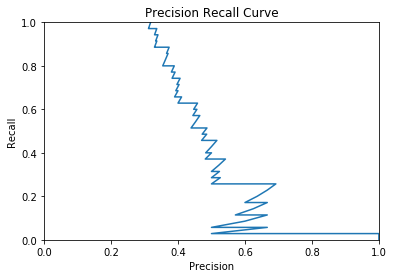

In [33]:
y_new = [(lambda u: 0 if u > 0 else 1)(u) for u in y]

logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size = .30, random_state = 42)

logreg.fit(X_train,y_train)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

### Using a Pipeline for Hyperparameter Tuning

Let's now use "the big guns", precisely a pipeline, which will allow us to pick the best fitting model with respect to the recall between the following models:
- a Logisitic Regressor
- a K-Neighbors Classifier
- a Random Forest Classifier

In [458]:
y_new = [(lambda u: 0 if u > 0 else 1)(u) for u in y]

pipeline = Pipeline([ ('classifier' , RandomForestClassifier())
                    ])

param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-5, 8, 15),
    'classifier__solver' : ['liblinear']},
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': np.arange(1,50)},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
    ]

# param_grid =  {'classifier' : [RandomForestClassifier()],
#     'classifier__class_weight': ['balanced'],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}

clf = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'recall', cv = 5)#, verbose=True, n_jobs=-1)

best_clf = clf.fit(X, y_new)

In [459]:
#print(best_clf)
print("Best params", best_clf.best_params_)
print("Best score", best_clf.best_score_)
#for param_name in sorted(param_grid[1].keys()):
#    print("%s: %s" %(param_name, best_clf.best_params_[param_name]))

Best params {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'), 'classifier__n_neighbors': 1}
Best score 0.439047619047619


### Testing the best Classifier from the Pipeline on a train-test split

In [460]:
#clf = RandomForestClassifier( max_features= 6, n_estimators= 100, class_weight= 'balanced', random_state= 32)
#clf = LogisticRegression(C = 1e-05, penalty= 'l2', solver ='liblinear')
clf = KNeighborsClassifier(n_neighbors=1)

In [468]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(y_test.value_counts(),'\n', pd.DataFrame(y_pred)[0].value_counts())

[[14 18]
 [25 55]]
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        32
           1       0.75      0.69      0.72        80

    accuracy                           0.62       112
   macro avg       0.56      0.56      0.56       112
weighted avg       0.64      0.62      0.63       112

1    80
0    32
Name: yffs, dtype: int64 
 1    73
0    39
Name: 0, dtype: int64


In [34]:
# GridSearchCV using Logistic Regressor (C - value) and Penalty

# param_grid = {'C': np.logspace(-5, 8, 15),'penalty': ['l1', 'l2']}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, verbose=0)
# logreg_cv.fit(X, y)
# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

# GridSearchCV using KNeighbors (knn)

# param_grid = {'n_neighbors':np.arange(1, 50)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv = 10)
# knn_cv.fit(X, y)
# print(knn_cv.best_params_)
# print(knn_cv.best_score_)


# GridSearchCV using KNeighbors (knn) but for VARYING threshold

# param_grid = {'n_neighbors':np.arange(1,30)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv = 10)

# bp_list=[]
# bs_list=[]
# for thresh in np.arange(1,100,5):
#     y = wr2.yffs
#     y = splitter(y, thresh)
#     knn_cv.fit(X, y)
#     bp_list.append(knn_cv.best_params_)
#     bs_list.append(knn_cv.best_score_)

For thresholds varying between 1 and 200, we perform a GridSearch Cross Validation over 10 folds on the ridge regressor, which aims to return the best score of the predictive model and the best alpha parameter each time. The reason why we aim for 10 folds is because we want eventually test our model against a unique year in the draft, which we represent 10% of our data.

We store the results for flop-data and success-data in two lists, which we display below